In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_parquet('Data/job_info_marconi100.parquet')
df.head(10)
# df.head(3).to_csv('job_info_sample.csv', index=False)

,accrue_time,alloc_node,alloc_sid,array_job_id,array_max_tasks,array_task_id,array_task_str,array_task_throttle,assoc_id,batch_flag,...,tres_bind,tres_freq,tres_per_job,tres_per_node,tres_per_socket,tres_per_task,tres_req_str,user_id,wait4switch,wckey
0,NaT,None,NaN,3914765,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:4,None,None,None,907,NaN,None
1,NaT,None,NaN,4474895,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:4,None,None,None,907,NaN,None
2,NaT,None,NaN,3443783,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1234,NaN,None
3,NaT,None,NaN,4272296,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1624,NaN,None
4,NaT,None,NaN,5520135,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,587,NaN,None
5,NaT,None,NaN,2782294,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:4,None,None,None,501,NaN,None
6,NaT,None,NaN,5910960,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:2,None,None,None,1254,NaN,None
7,NaT,None,NaN,4555378,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1624,NaN,None
8,NaT,None,NaN,1934765,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,1624,NaN,None
9,NaT,None,NaN,4196069,NaN,NaN,None,NaN,NaN,NaN,...,None,None,None,gres:gpu:1,None,None,None,587,NaN,None


In [3]:
# clean data
# 数据清理：筛选出已完成的作业
df = df[df['job_state'] == 'COMPLETED'].copy()  # 使用 .copy() 生成副本，避免警告

# 特征工程：提取运行时间，计算作业的持续时间
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
df['runtime_hours'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600  # 以小时为单位

# 提取 GPU 数量
df['gpu_count'] = df['tres_per_node'].str.extract(r'gpu:(\d+)').astype(float).fillna(0)

# 提取 CPU 数量
df['cpu_count'] = df['num_cpus'].astype(float)

# 处理内存需求
df['memory_requested'] = df['mem_per_node'].fillna(128)  # 使用每个节点的内存需求，缺失值填充为 0

In [4]:
cpu_power_min, cpu_power_max = 200/df['cpu_count'].max(), 250/df['cpu_count'].max()  # 每个 CPU 的功耗范围
gpu_power_min, gpu_power_max = 300, 350  # 每个 GPU 的功耗范围
memory_power_min, memory_power_max = 20, 30  # 每 100 GB 的内存功耗范围
# 计算每个作业的总功耗范围
df['power_min'] = (df['cpu_count'] * cpu_power_min) + \
                  (df['gpu_count'] * gpu_power_min) + \
                  ((df['memory_requested'] / 100) * memory_power_min)

df['power_max'] = (df['cpu_count'] * cpu_power_max) + \
                  (df['gpu_count'] * gpu_power_max) + \
                  ((df['memory_requested'] / 100) * memory_power_max)

df['energy_min'] = df['power_min'] * df['runtime_hours']
df['energy_max'] = df['power_max'] * df['runtime_hours']
df['energy'] = (df['energy_min'] + df['energy_max']) / 2  # 计算平均能耗

print(df[['job_id', 'cpu_count', 'gpu_count', 'memory_requested', 'power_min', 'power_max', 'energy_min', 'energy_max', 'energy']].head(3))

    job_id  cpu_count  gpu_count  memory_requested    power_min    power_max  \
0  3914765       64.0        4.0               128  1225.990625  1438.888281   
1  4474895       64.0        4.0               128  1225.990625  1438.888281   
2  3443783        4.0        1.0               128   325.624414   388.430518   

   energy_min  energy_max     energy  
0    7.492165    8.793206   8.142686  
1    7.492165    8.793206   8.142686  
2   44.230650   52.761812  48.496231  


In [5]:
import matplotlib.pyplot as plt
def plot_energy_distribution(data, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(title)
    plt.xlabel('Energy (Watt-hours)')
    plt.ylabel('Frequency')
    plt.show()

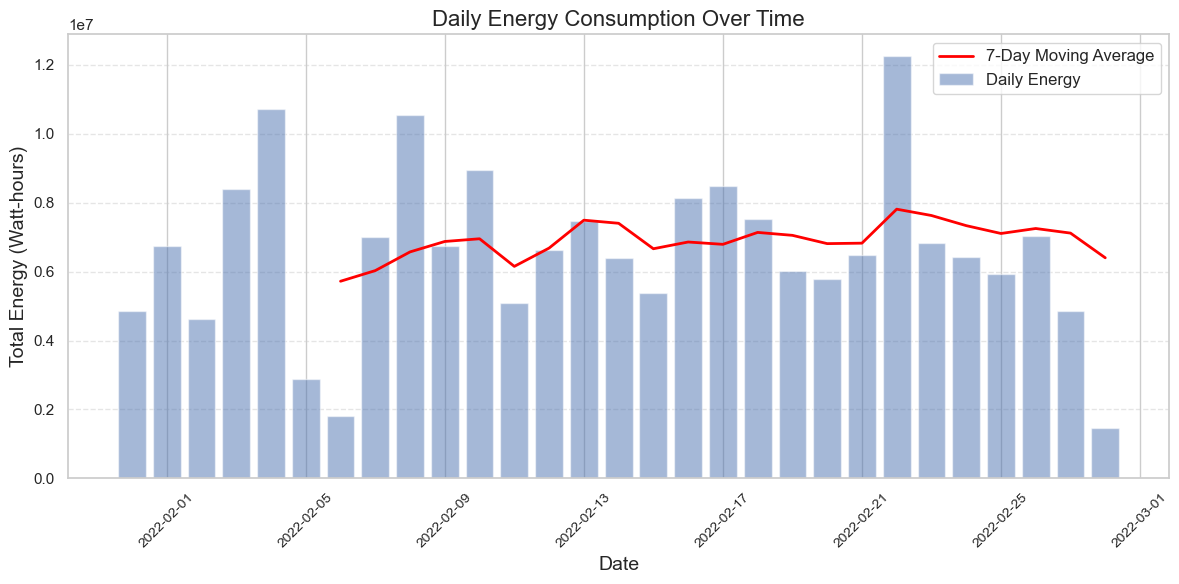

In [6]:
# Resample by day and calculate total energy
daily_energy = df.set_index('start_time').resample('D')['energy'].sum()

# Plot daily energy as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(daily_energy.index, daily_energy, alpha=0.5, label='Daily Energy')

# Add a 7-day moving average for smoothing
plt.plot(daily_energy.index, daily_energy.rolling(window=7).mean(), color='red', linewidth=2, label='7-Day Moving Average')

# Chart title and labels
plt.title('Daily Energy Consumption Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Energy (Watt-hours)', fontsize=14)
plt.legend(fontsize=12)

# Optimize x-axis date display
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

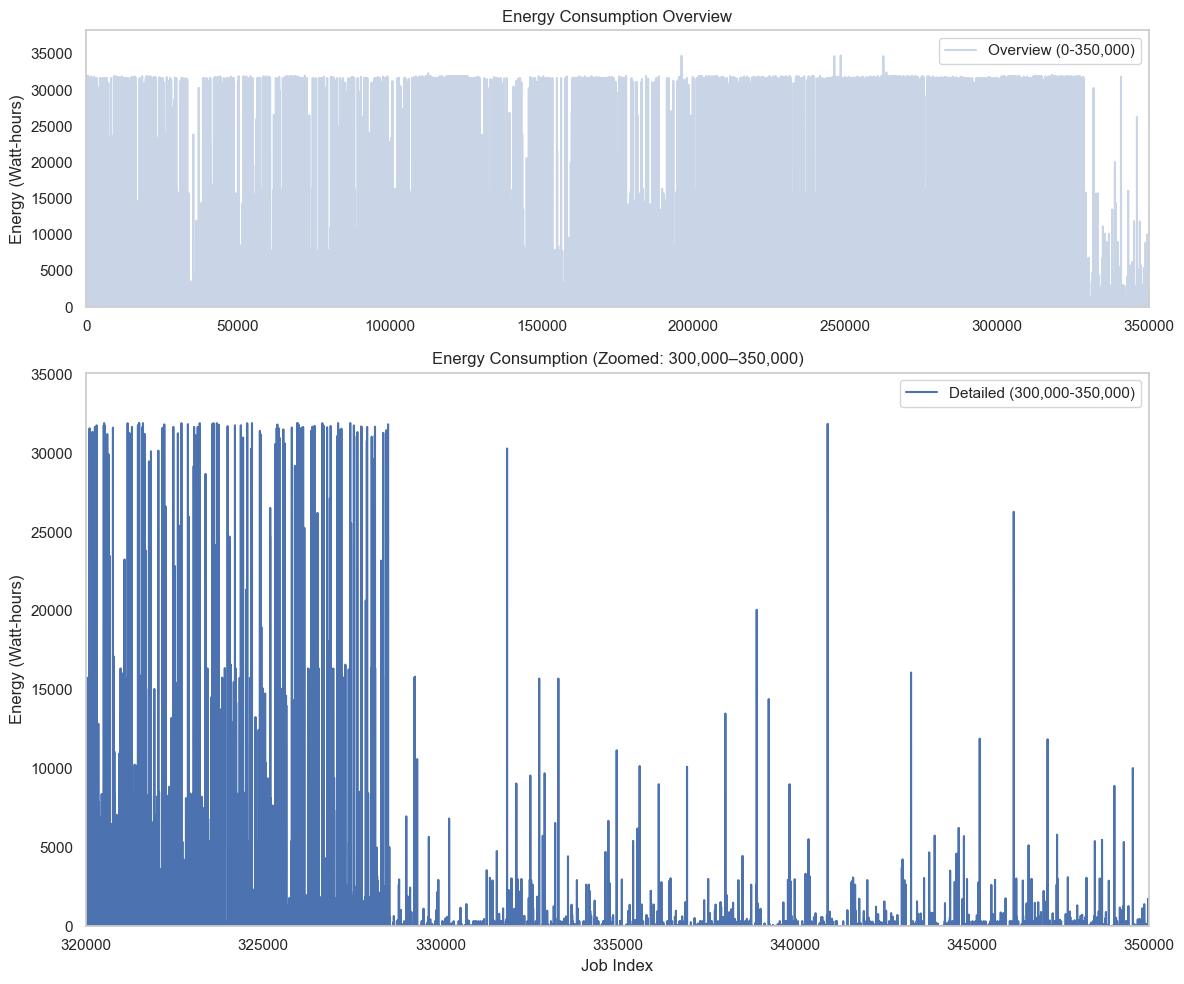

In [7]:
import matplotlib.pyplot as plt

# Create the figure with two subplots: one for the overview, one for the detailed zoom-in
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

# Overview plot: 0 to 350,000
axs[0].plot(df.index, df['energy'], linestyle='-', alpha=0.3, label='Overview (0-350,000)')
axs[0].set_xlim(0, 350000)
axs[0].set_ylim(0, max(df['energy']) * 1.1)
axs[0].set_title('Energy Consumption Overview')
axs[0].set_ylabel('Energy (Watt-hours)')
axs[0].grid()
axs[0].legend()

# Zoom-in plot: 300,000 to 350,000
detailed = df[(df.index >= 320000)]
axs[1].plot(detailed.index, detailed['energy'], linestyle='-', label='Detailed (300,000-350,000)')
axs[1].set_xlim(320000, 350000)
axs[1].set_ylim(0, max(detailed['energy']) * 1.1)
axs[1].set_title('Energy Consumption (Zoomed: 300,000–350,000)')
axs[1].set_xlabel('Job Index')
axs[1].set_ylabel('Energy (Watt-hours)')
axs[1].grid()
axs[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

/Users/wangzepeng/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


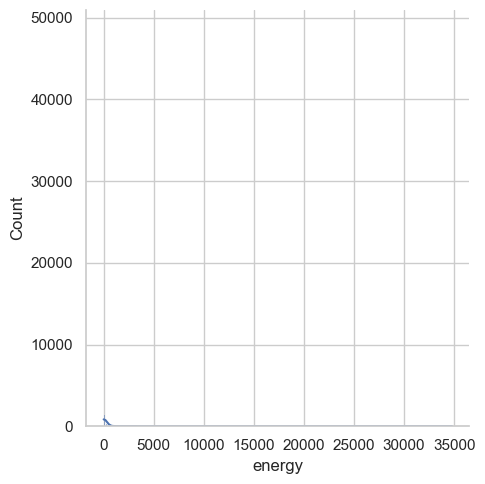

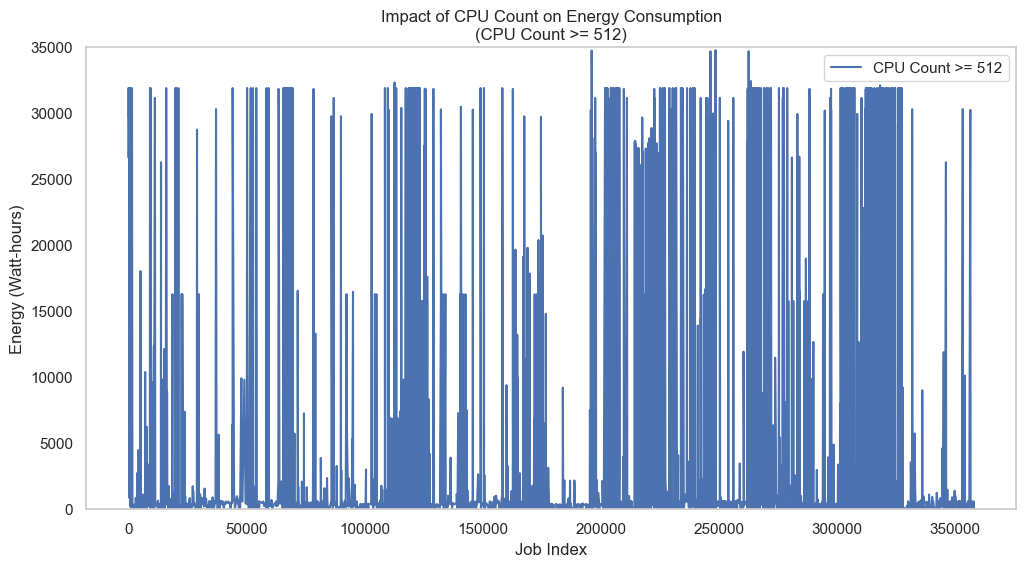

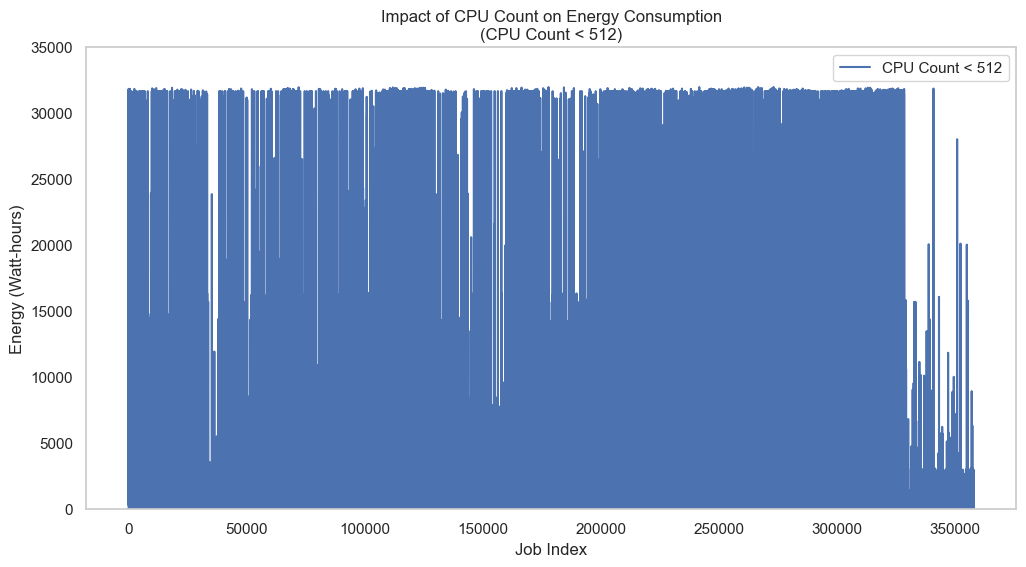

In [8]:
gpu_only_jobs = df[df['cpu_count'] >= 512]
cpu_only_jobs = df[df['cpu_count'] < 512]

y_max_limit = 35000


# Create the first plot for CPU count >= 512
plt.figure(figsize=(12, 6))
plt.plot(gpu_only_jobs.index, gpu_only_jobs['energy'], linestyle='-', label='CPU Count >= 512')
plt.title('Impact of CPU Count on Energy Consumption\n(CPU Count >= 512)')
plt.xlabel('Job Index')
plt.ylabel('Energy (Watt-hours)')
plt.grid()
plt.ylim(0, y_max_limit)  # Set y-axis limit
plt.legend()
plt.show()

# Create the second plot for CPU count < 512
plt.figure(figsize=(12, 6))
plt.plot(cpu_only_jobs.index, cpu_only_jobs['energy'], linestyle='-', label='CPU Count < 512')
plt.title('Impact of CPU Count on Energy Consumption\n(CPU Count < 512)')
plt.xlabel('Job Index')
plt.ylabel('Energy (Watt-hours)')
plt.grid()
plt.ylim(0, y_max_limit)  # Set y-axis limit
plt.legend()
plt.show()

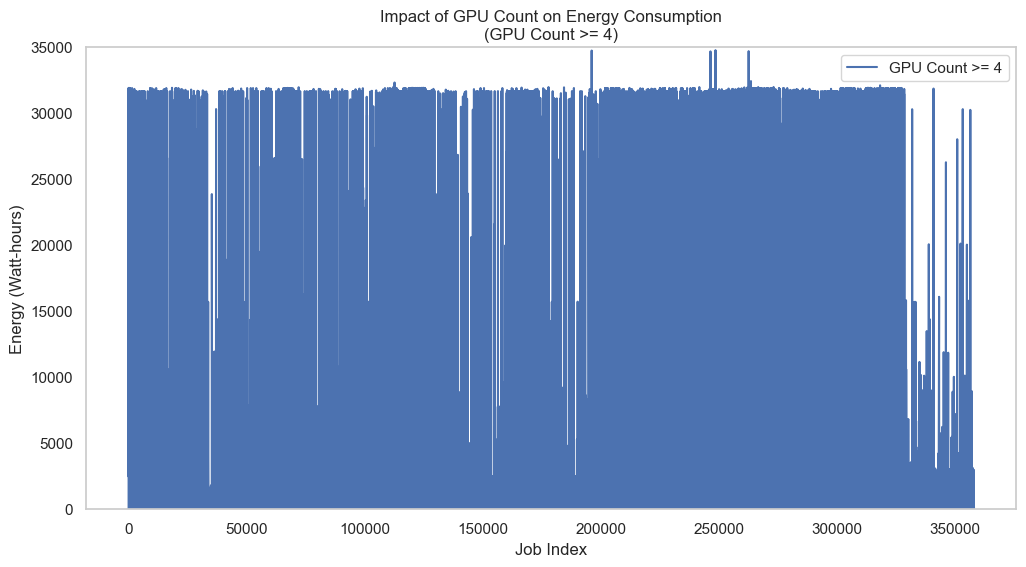

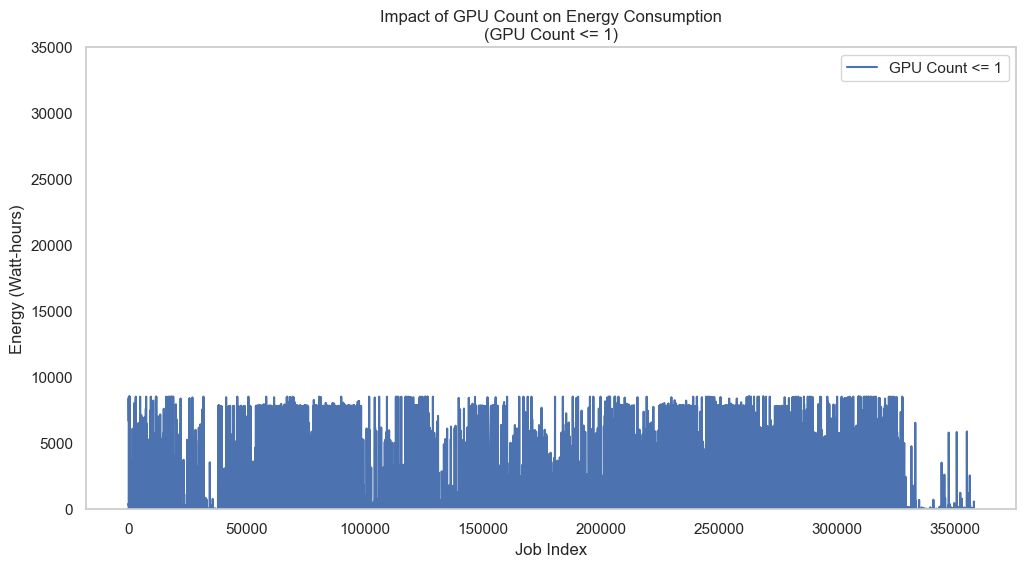

In [9]:
# Filter data based on GPU count
gpu_high_jobs = df[df['gpu_count'] >= 4]
gpu_low_jobs = df[df['gpu_count'] <= 1]

# Create the first plot for GPU count >= 4
plt.figure(figsize=(12, 6))
plt.plot(gpu_high_jobs.index, gpu_high_jobs['energy'], linestyle='-', label='GPU Count >= 4')
plt.title('Impact of GPU Count on Energy Consumption\n(GPU Count >= 4)')
plt.xlabel('Job Index')
plt.ylabel('Energy (Watt-hours)')
plt.grid()
plt.ylim(0, y_max_limit)  # Set y-axis limit
plt.legend()
plt.show()

# Create the second plot for GPU count < 4
plt.figure(figsize=(12, 6))
plt.plot(gpu_low_jobs.index, gpu_low_jobs['energy'], linestyle='-', label='GPU Count <= 1')
plt.title('Impact of GPU Count on Energy Consumption\n(GPU Count <= 1)')
plt.xlabel('Job Index')
plt.ylabel('Energy (Watt-hours)')
plt.grid()
plt.ylim(0, y_max_limit)  # Set y-axis limit
plt.legend()
plt.show()

In [11]:
# 碳强度 (kg CO2/kWh)
carbon_intensity = 0.000233


# 设置硬件的嵌入碳排放参数和功耗
cpu_power_max = 250        # 每个 CPU 的最大功耗 (W)
gpu_power_max = 350        # 每个 GPU 的最大功耗 (W)
memory_power_min = 20      # 每 100 GB 内存的最小功耗 (W)
carbon_cpu = 1             # 每个 CPU 的嵌入碳排放量 (kg CO2)
carbon_gpu = 200           # 每个 GPU 的嵌入碳排放量 (kg CO2)
carbon_memory = 1          # 每 GB 内存的嵌入碳排放量 (kg CO2)
lifecycle_hours = 5 * 365 * 24  # 生命周期以小时计算

cpu_power_max_kwh = cpu_power_max / 1000  # 转为 kWh
gpu_power_max_kwh = gpu_power_max / 1000
memory_power_min_kwh = memory_power_min / 1000


# 计算运行时
df['runtime_hours'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600 

# 修正嵌入碳足迹计算
df['embodied_footprint'] = (
    (df['cpu_count'] * carbon_cpu) +
    (df['gpu_count'] * carbon_gpu) +
    (df['memory_requested'] * carbon_memory)
)*df['runtime_hours'] / lifecycle_hours

# 修正操作碳足迹计算
df['operational_footprint'] = (
    (df['cpu_count'] * cpu_power_max_kwh * df['runtime_hours']) +
    (df['gpu_count'] * gpu_power_max_kwh * df['runtime_hours']) +
    (df['memory_requested'] * memory_power_min_kwh * df['runtime_hours'])
) * carbon_intensity
runtime_threshold = 24 * 7  # 最长运行时间为1周
df = df[df['runtime_hours'] <= runtime_threshold]  # 过滤异常大值
# 计算总碳足迹
df['total_footprint'] = df['embodied_footprint'] + df['operational_footprint']

In [12]:
df.head(5)

,accrue_time,alloc_node,alloc_sid,array_job_id,array_max_tasks,array_task_id,array_task_str,array_task_throttle,assoc_id,batch_flag,...,cpu_count,memory_requested,power_min,power_max,energy_min,energy_max,energy,embodied_footprint,operational_footprint,total_footprint
0,NaT,None,NaN,3914765,NaN,NaN,None,NaN,NaN,NaN,...,64.0,128,1225.990625,1438.888281,7.492165,8.793206,8.142686,0.000138,0.000028,0.000167
1,NaT,None,NaN,4474895,NaN,NaN,None,NaN,NaN,NaN,...,64.0,128,1225.990625,1438.888281,7.492165,8.793206,8.142686,0.000138,0.000028,0.000167
2,NaT,None,NaN,3443783,NaN,NaN,None,NaN,NaN,NaN,...,4.0,128,325.624414,388.430518,44.230650,52.761812,48.496231,0.001030,0.000124,0.001153
5,NaT,None,NaN,2782294,NaN,NaN,None,NaN,NaN,NaN,...,128.0,128,1226.381250,1439.376563,11005.749734,12917.205168,11961.477451,0.216363,0.075192,0.291555
6,NaT,None,NaN,5910960,NaN,NaN,None,NaN,NaN,NaN,...,32.0,128,625.795313,738.644141,14869.418121,17550.800318,16210.109220,0.303791,0.062338,0.366130


 CPU、GPU、内存和运行时间在整个碳足迹中的占比

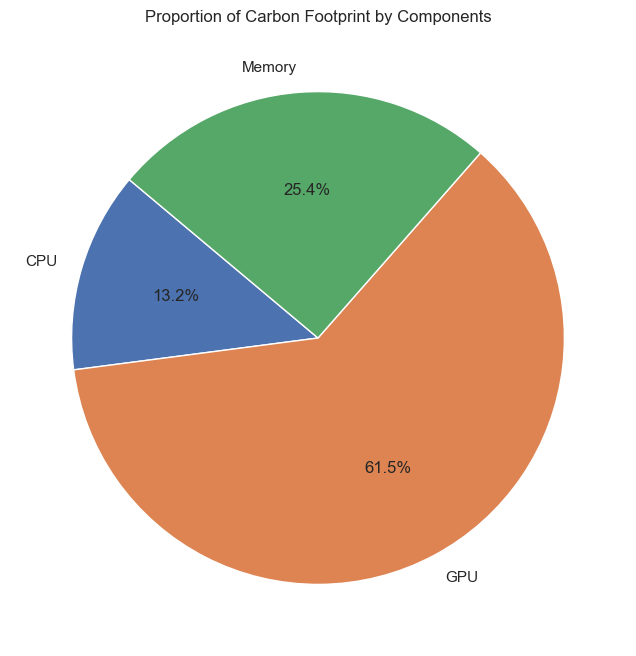

In [13]:
import matplotlib.pyplot as plt

# 计算 CPU、GPU、内存和运行时间的碳足迹总和
cpu_footprint = (df['cpu_count'] * carbon_cpu).sum()
gpu_footprint = (df['gpu_count'] * carbon_gpu).sum()
memory_footprint = (df['memory_requested'] * carbon_memory).sum()
runtime_footprint = ((df['cpu_count'] * cpu_power_max) + 
                     (df['gpu_count'] * gpu_power_max) + 
                     (df['memory_requested'] / 100 * memory_power_min)).sum() * (df['runtime_hours'] / lifecycle_hours).sum()

# 将这些值存入一个字典
footprint_data = {
    'CPU': cpu_footprint,
    'GPU': gpu_footprint,
    'Memory': memory_footprint
}

# 转换为 DataFrame 计算占比
total_footprint = sum(footprint_data.values())
percentages = {k: v / total_footprint * 100 for k, v in footprint_data.items()}

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(percentages.values(), labels=percentages.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Carbon Footprint by Components')
plt.show()

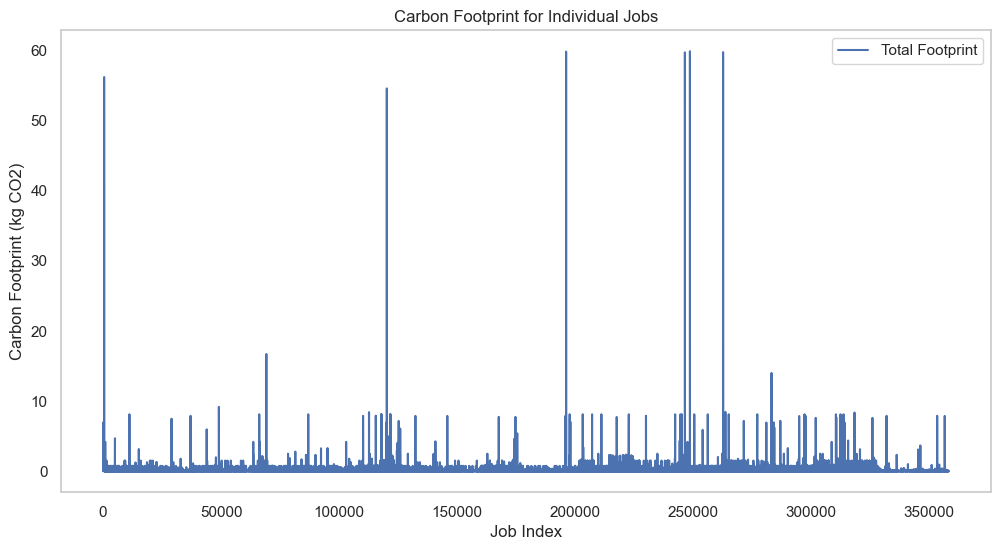

In [14]:
plt.figure(figsize=(12, 6))

# 绘制作业的碳足迹曲线
plt.plot(df.index, df['total_footprint'], linestyle='solid', label='Total Footprint')

# # 找到超过200的作业
# high_footprint_jobs = df[(df['total_footprint'] > 20) & (df.index <= 200000)]
# print(high_footprint_jobs.reset_index())
# 
# # 在图上标注符合条件的作业
# # for idx, value in high_footprint_jobs[['total_footprint']].itertuples():
# #     plt.text(idx, value, f'{idx}', color='red', fontsize=10, ha='center', va='bottom')

# 添加标题和标签
plt.title('Carbon Footprint for Individual Jobs')
plt.xlabel('Job Index')
plt.ylabel('Carbon Footprint (kg CO2)')
plt.grid()
plt.legend()
plt.show()

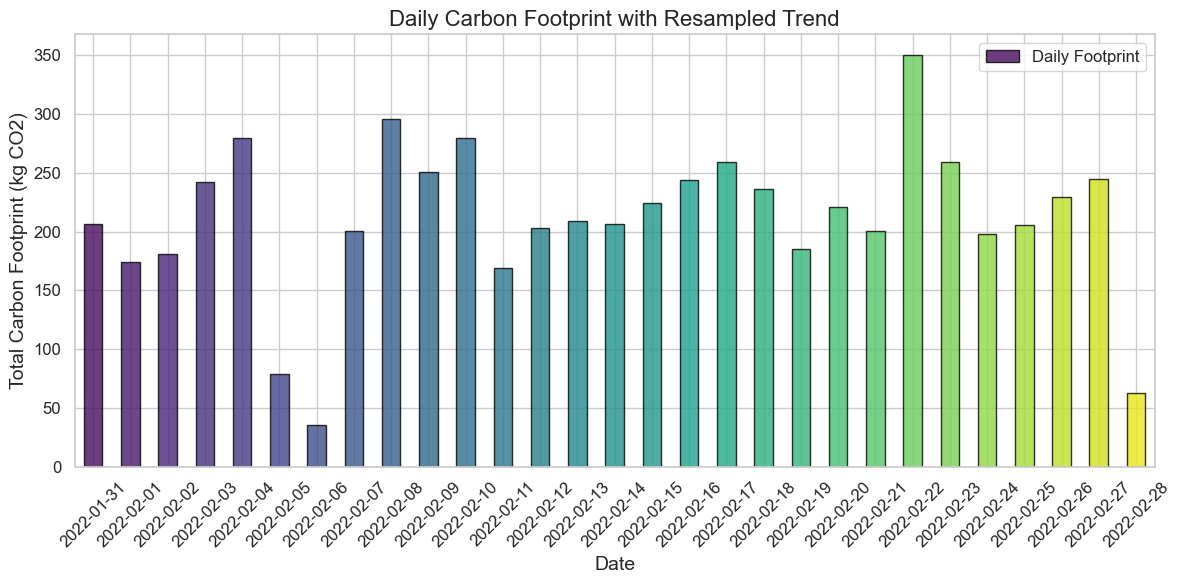

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 提取日期
df['date'] = df['start_time'].dt.date  # 提取日期

# 计算每日总碳足迹
daily_footprint = df.groupby('date')['total_footprint'].sum()

# 计算按天重采样的碳足迹（累计曲线数据）
daily_resampled_footprint = df.set_index('start_time').resample('D')['total_footprint'].sum()

# 设置柱状图颜色
colors = sns.color_palette("viridis", len(daily_footprint))

# 绘制柱状图
plt.figure(figsize=(12, 6))
daily_footprint.plot(kind='bar', color=colors, edgecolor='black', alpha=0.8, label='Daily Footprint')



# 添加标题和标签
plt.title('Daily Carbon Footprint with Resampled Trend', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Carbon Footprint (kg CO2)', fontsize=14)

# 调整 x 轴和 y 轴标签
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# 添加图例
plt.legend(fontsize=12)

# 显示图表
plt.tight_layout()
plt.show()

## CPU，GPU，Memory

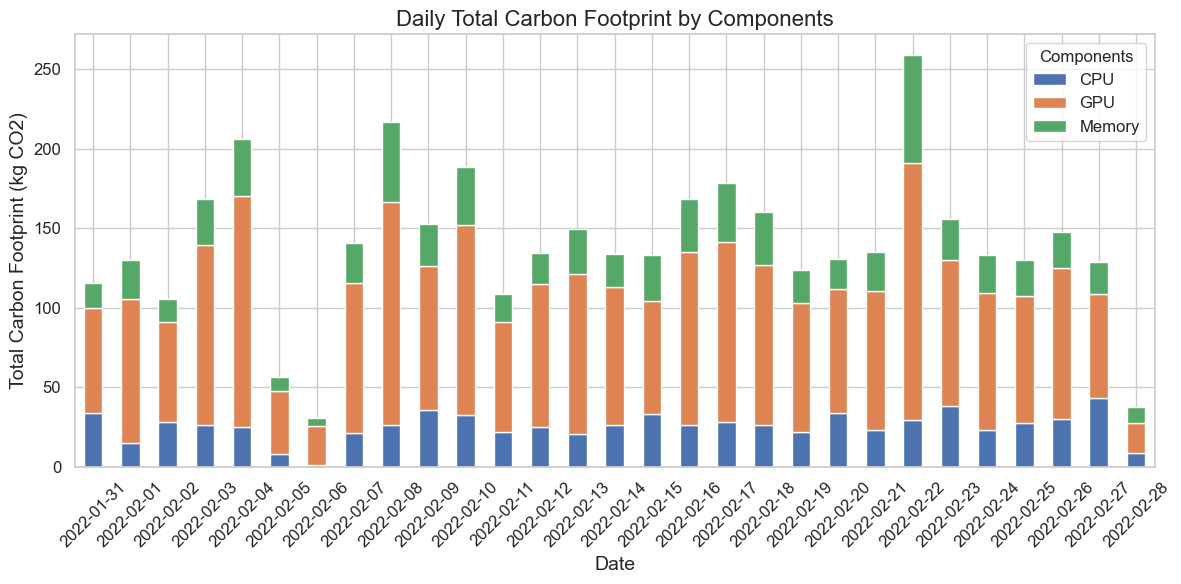

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算 CPU、GPU 和内存的每日碳足迹
df['cpu_footprint'] = df['cpu_count'] * carbon_cpu * (df['runtime_hours'] / lifecycle_hours)
df['gpu_footprint'] = df['gpu_count'] * carbon_gpu * (df['runtime_hours'] / lifecycle_hours)
df['memory_footprint'] = df['memory_requested'] * carbon_memory * (df['runtime_hours'] / lifecycle_hours)

# 按天汇总
daily_footprint_cpu = df.groupby('date')['cpu_footprint'].sum()
daily_footprint_gpu = df.groupby('date')['gpu_footprint'].sum()
daily_footprint_memory = df.groupby('date')['memory_footprint'].sum()

# 合并数据为 DataFrame
daily_footprint_components = pd.DataFrame({
    'CPU': daily_footprint_cpu,
    'GPU': daily_footprint_gpu,
    'Memory': daily_footprint_memory
})

# 绘制堆叠柱状图
daily_footprint_components.plot(
    kind='bar', stacked=True, figsize=(12, 6)
)

# 添加图表信息
plt.title('Daily Total Carbon Footprint by Components', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Carbon Footprint (kg CO2)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Components', fontsize=12)
plt.tight_layout()
plt.show()

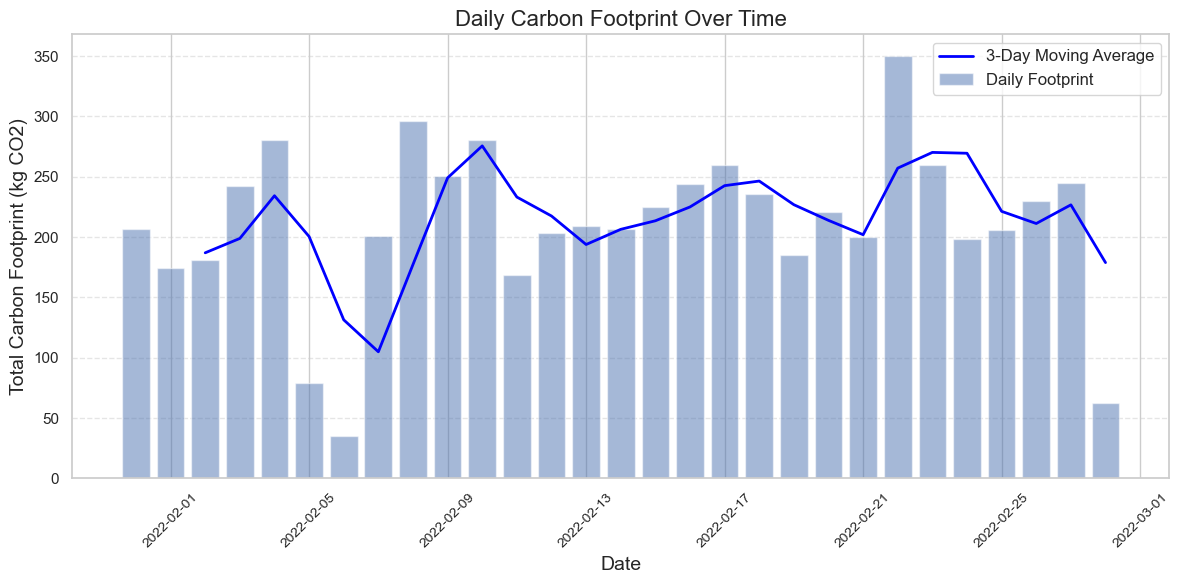

In [29]:
plt.figure(figsize=(12, 6))

# 按日期重采样并计算每日碳排放量
daily_carbon = df.set_index('start_time').resample('D')['total_footprint'].sum()

# 绘制柱状图表示每日碳排放量
plt.bar(daily_carbon.index, daily_carbon, alpha=0.5, label='Daily Footprint')

# 叠加平滑曲线（移动平均）
plt.plot(daily_carbon.index, daily_carbon.rolling(window=3).mean(), color='blue', linewidth=2, label='3-Day Moving Average')

# 图表标题和标签
plt.title('Daily Carbon Footprint Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Carbon Footprint (kg CO2)', fontsize=14)
plt.legend(fontsize=12)

# 优化横轴日期显示
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

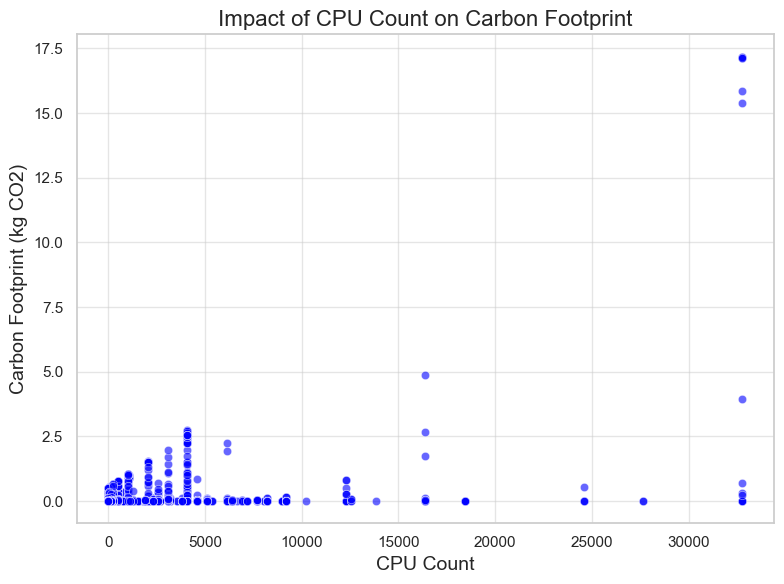

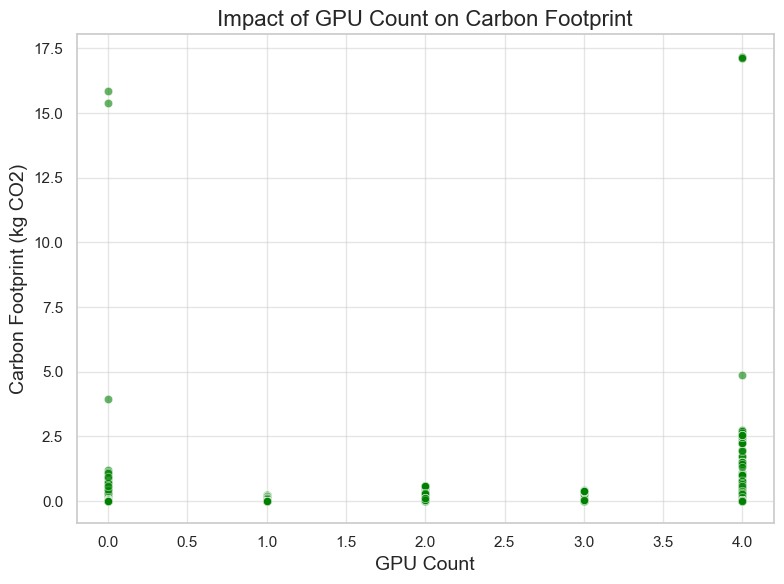

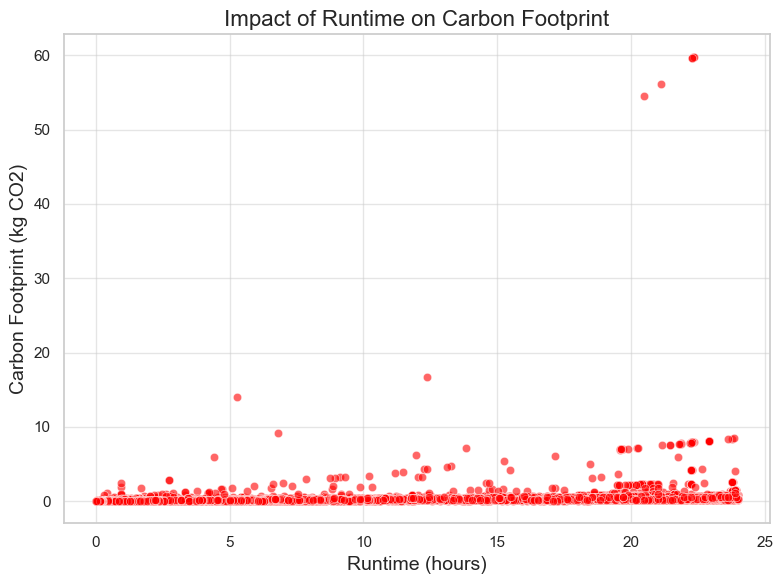

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图形风格
sns.set(style="whitegrid")

# 图1: CPU数量 vs 碳排放量
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cpu_count', y='embodied_footprint', data=df, alpha=0.6, color='blue')
plt.title('Impact of CPU Count on Carbon Footprint', fontsize=16)
plt.xlabel('CPU Count', fontsize=14)
plt.ylabel('Carbon Footprint (kg CO2)', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 图2: GPU数量 vs 碳排放量
plt.figure(figsize=(8, 6))
sns.scatterplot(x='gpu_count', y='embodied_footprint', data=df, alpha=0.6, color='green')
plt.title('Impact of GPU Count on Carbon Footprint', fontsize=16)
plt.xlabel('GPU Count', fontsize=14)
plt.ylabel('Carbon Footprint (kg CO2)', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 图3: 运行时间 vs 碳排放量
plt.figure(figsize=(8, 6))
sns.scatterplot(x='runtime_hours', y='total_footprint', data=df, alpha=0.6, color='red')
plt.title('Impact of Runtime on Carbon Footprint', fontsize=16)
plt.xlabel('Runtime (hours)', fontsize=14)
plt.ylabel('Carbon Footprint (kg CO2)', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

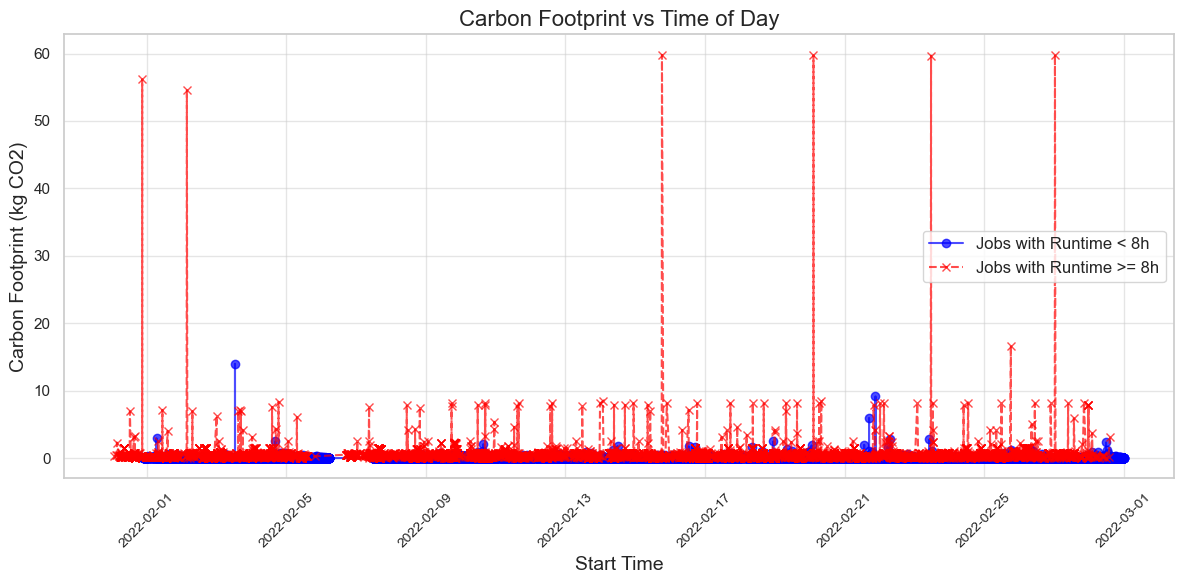

In [31]:
import matplotlib.pyplot as plt

# 假设 df 包含以下字段：
# - 'start_time': 作业开始时间，datetime 格式
# - 'runtime_hours': 作业运行时间，以小时为单位
# - 'embodied_footprint': 作业的碳足迹

# 将作业分为两组：运行时间小于 8 小时和大于等于 8 小时
df_short_jobs = df[df['runtime_hours'] < 8]
df_long_jobs = df[df['runtime_hours'] >= 8]

# 按开始时间排序
df_short_jobs = df_short_jobs.sort_values(by='start_time')
df_long_jobs = df_long_jobs.sort_values(by='start_time')

# 绘图
plt.figure(figsize=(12, 6))

# 绘制运行时间小于 8 小时的作业碳足迹
plt.plot(df_short_jobs['start_time'], df_short_jobs['total_footprint'],
         label='Jobs with Runtime < 8h', linestyle='-', marker='o', color='blue', alpha=0.7)

# 绘制运行时间大于等于 8 小时的作业碳足迹
plt.plot(df_long_jobs['start_time'], df_long_jobs['total_footprint'],
         label='Jobs with Runtime >= 8h', linestyle='--', marker='x', color='red', alpha=0.7)

# 添加图表标题和轴标签
plt.title('Carbon Footprint vs Time of Day', fontsize=16)
plt.xlabel('Start Time', fontsize=14)
plt.ylabel('Carbon Footprint (kg CO2)', fontsize=14)

# 添加图例和网格
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# 调整 x 轴显示
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# 显示图表
plt.show()

In [41]:
import requests

data_in_uk = {}

url = 'https://api.carbonintensity.org.uk/intensity/date/'
for date in pd.date_range('2022-02-01', '2022-03-01'):
    print(url + str(date.date()))
    response = requests.get(url + str(date.date()))
    data = response.json()
    total = sum([i['intensity']['actual'] for i in data['data']])/len([i['intensity']['actual'] for i in data['data']])

    data_in_uk[date.date()] = total

print(data_in_uk)

https://api.carbonintensity.org.uk/intensity/date/2022-02-01
https://api.carbonintensity.org.uk/intensity/date/2022-02-02
https://api.carbonintensity.org.uk/intensity/date/2022-02-03
https://api.carbonintensity.org.uk/intensity/date/2022-02-04
https://api.carbonintensity.org.uk/intensity/date/2022-02-05
https://api.carbonintensity.org.uk/intensity/date/2022-02-06
https://api.carbonintensity.org.uk/intensity/date/2022-02-07
https://api.carbonintensity.org.uk/intensity/date/2022-02-08
https://api.carbonintensity.org.uk/intensity/date/2022-02-09
https://api.carbonintensity.org.uk/intensity/date/2022-02-10


KeyboardInterrupt: 

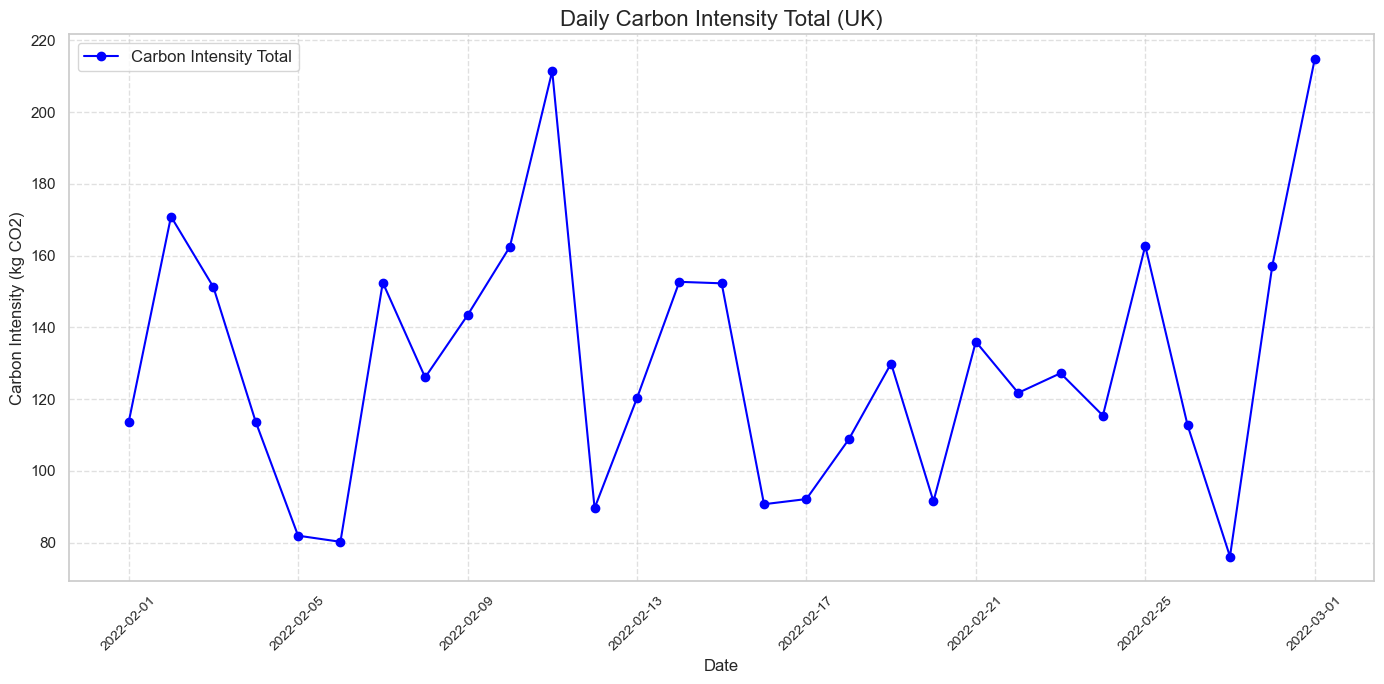

In [33]:
dates = list(data_in_uk.keys())
values = list(data_in_uk.values())
# 可视化
plt.figure(figsize=(14, 7))
plt.plot(dates, values, marker='o', linestyle='-', color='blue', label='Carbon Intensity Total')

# 添加标题和轴标签
plt.title('Daily Carbon Intensity Total (UK)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Carbon Intensity (kg CO2)', fontsize=12)

# 添加网格线和图例
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=12)

# 显示图表
plt.tight_layout()
plt.show()

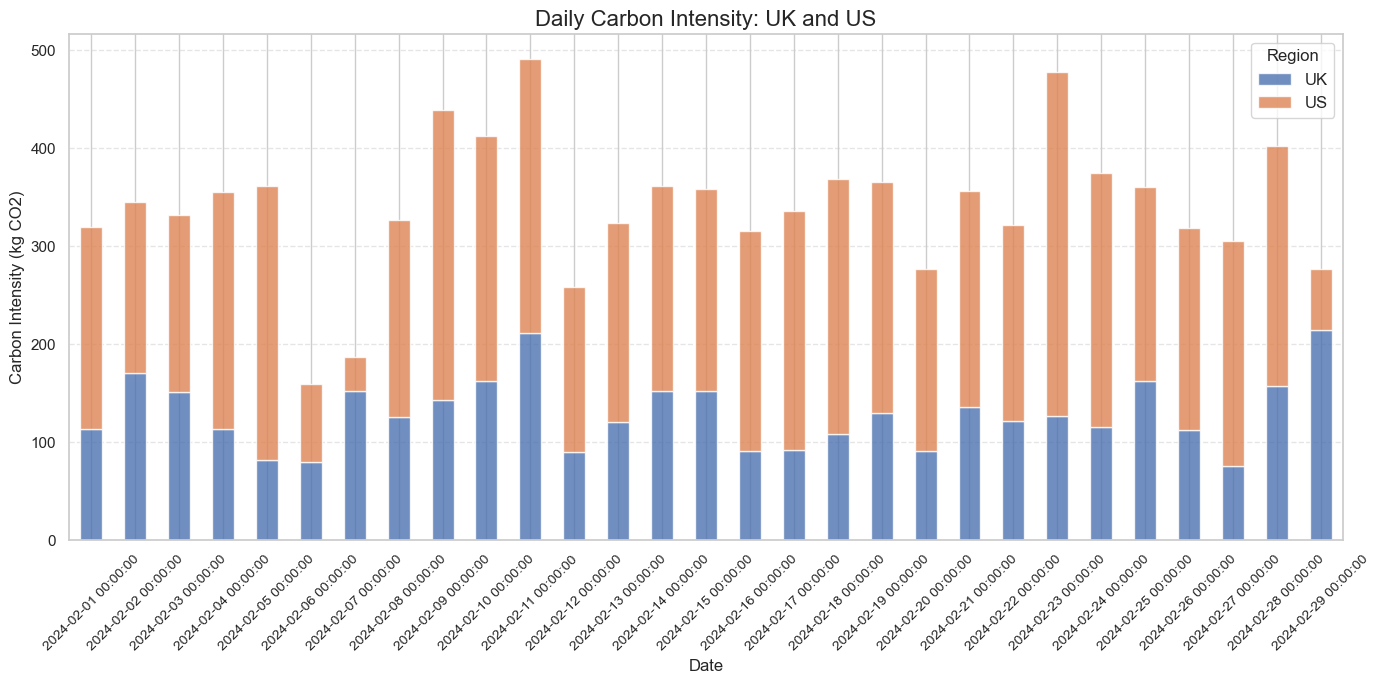

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 uk_data 和 us_data 是英国和美国的数据 DataFrame
# 包括日期 (Date) 和碳排放量 (Carbon Intensity)


uk_data = pd.DataFrame({
    'Date': pd.date_range(start='2024-02-01', periods=29),
    'Carbon Intensity': values
})

us_data = pd.DataFrame({
    'Date': pd.date_range(start='2024-02-01', periods=29),
    'Carbon Intensity': daily_carbon
})

# 合并数据
uk_data['Region'] = 'UK'
us_data['Region'] = 'US'
combined_data = pd.concat([uk_data, us_data])

# 按日期和区域分组计算碳排放总量
pivot_data = combined_data.pivot(index='Date', columns='Region', values='Carbon Intensity')

# 绘制堆叠柱状图
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    alpha=0.8
)

# 添加标题和轴标签
plt.title('Daily Carbon Intensity: UK and US', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Carbon Intensity (kg CO2)', fontsize=12)
plt.legend(title='Region', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# 显示图表
plt.show()

In [42]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# 定义起始和结束日期
start_date = datetime(2022, 2, 1)
end_date = datetime(2022, 3, 1)

# 初始化结果字典
hourly_emissions = {hour: [] for hour in range(24)}

# 循环请求每一天的数据
current_date = start_date
while current_date < end_date:
    # 格式化日期字符串
    date_str = current_date.strftime('%Y-%m-%d')
    # 构造 API 请求 URL
    url = f"https://api.carbonintensity.org.uk/intensity/date/{date_str}"
    
    try:
        # 发起 GET 请求
        response = requests.get(url)
        response.raise_for_status()  # 检查请求是否成功
        data = response.json()
        
        # 解析数据
        for entry in data['data']:
            from_time = datetime.fromisoformat(entry['from'].replace('Z', '+00:00'))
            hour = from_time.hour
            actual_intensity = entry['intensity']['actual']
            hourly_emissions[hour].append(actual_intensity)
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {date_str}: {e}")
    
    # 增加一天
    current_date += timedelta(days=1)

# 计算每小时的平均碳排放量
average_hourly_emissions = {hour: sum(values) / len(values) if values else 0 for hour, values in hourly_emissions.items()}

# 转换为 DataFrame
df_hourly_emissions = pd.DataFrame(list(average_hourly_emissions.items()), columns=['Hour', 'Average Emission (kg CO2)'])
df_hourly_emissions.sort_values(by='Hour', inplace=True)

# 保存为 CSV 文件（可选）
# df_hourly_emissions.to_csv('hourly_average_emissions.csv', index=False)

# 显示数据
print(df_hourly_emissions)

    Hour  Average Emission (kg CO2)
0      0                  91.214286
1      1                  89.535714
2      2                  86.375000
3      3                  84.964286
4      4                  87.321429
5      5                  93.910714
6      6                 116.553571
7      7                 134.732143
8      8                 139.535714
9      9                 137.517857
10    10                 134.982143
11    11                 130.285714
12    12                 130.196429
13    13                 128.607143
14    14                 133.410714
15    15                 146.017857
16    16                 163.196429
17    17                 167.232143
18    18                 168.125000
19    19                 166.571429
20    20                 158.232143
21    21                 138.017857
22    22                 115.285714
23    23                  95.892857


,Hour,Average Total Emission (kg CO2)
0,0,0.000267
1,1,0.000289
2,2,0.000261
3,3,0.000429
4,4,0.000439
5,5,0.000790
6,6,0.000425
7,7,0.000657
8,8,0.000336
9,9,0.000310
